# Assignment 2

**Team**\
Abhinay Kotla (1002195827)\
Wonjun Park (1002237177)

## Instruction

You will need to find a images set that you will use for classification using Convolutional Neural Networks. You will need to describe the process you followed for solving the problem. You will need to submit the Jupyter Notebook and the additional files may be needed for running the program.

Please, only one submission per group.

## Dataset Description and Its Purpose

**Intel Image Classification**

https://www.kaggle.com/datasets/puneet6060/intel-image-classification

To enhance regards to data communities, a data hackathon was held at the [online platform](https://www.analyticsvidhya.com/datahack/) by Intel. Photos are taken by [Jan Böttinger on Unsplash](https://unsplash.com/photos/27xFENkt-lc).

The dataset consists of various scenes or natural objects around the world, with the number of 25,000 images. The size of the images are 150 x 150, categorized as the following 6 labels:

* buildings
* forest
* glacier
* mountain
* sea
* street

Furthermore, the dataset is separated as train, test, and prediction, zipped into each file. About 14,000 images are in the train set, 3,000 images are in the test set, and 7,000 images are in the prediction set.

Again, the purpose of the dataset is to boost the participants solve image classification problems using neural network classifying these images with more accuracy.

## Notebook Contents

### 1. Dataset Preparation

* The dataset is downloaded from Kaggle, using `kagglehub`
* An image transformation is defined at the function `transform`

### 2. Model Initialization

The codes were based on `PyTorch`, a popular neural network framework to most researchers. The notebook defined a custom CNN model, inherited `torch.nn.module`.

### 3. Training and Testing

Using cross-entropy loss, the notebook trained the CNN-based model and stored the model which showed the best performance. The best model was tested on the test images.

### 4. Conclusion

With a confusion matrix, the notebook concluded the performance of the model and drawbacks of both the dataset and the model.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import ImageFolder

import os
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

from kagglehub import dataset_download

torch.manual_seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"PyTorch CUDA version: {torch.version.cuda}")

    print(f"GPU device name: {torch.cuda.get_device_name(0)}")

    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")

    total_memory = torch.cuda.get_device_properties(0).total_memory
    print(f"GPU total memory available: {total_memory / 1024**2:.2f} MB")

    reserved_memory = torch.cuda.memory_reserved(0)
    allocated_memory = torch.cuda.memory_allocated(0)
    free_memory = total_memory - allocated_memory
    print(f"GPU free memory: {free_memory / 1024**2:.2f} MB")
else:
    print("CUDA is not available on this system.")

Using device: cuda
PyTorch CUDA version: 12.4
GPU device name: Tesla T4
GPU memory allocated: 0.00 MB
GPU total memory available: 15095.06 MB
GPU free memory: 15095.06 MB


In [ ]:
path = dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

train_path = os.path.join(path, "seg_train", "seg_train")
test_path = os.path.join(path, "seg_test", "seg_test")

print("Classes in training folder:", os.listdir(train_path))

train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

batch_size = 64
num_workers = 6

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print("✅ Dataset loaded successfully!")
print("Classes:", train_dataset.classes)

100%|██████████| 346M/346M [00:02<00:00, 162MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2
Classes in training folder: ['sea', 'street', 'mountain', 'glacier', 'buildings', 'forest']
✅ Dataset loaded successfully!
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

The `transform` function is related to how to address image data. The following numbered bullets are about explanations;

1. **`transforms.Resize((150, 150))`**: Resizes the input image to a fixed size of 150x150 pixels. This ensures all images have the same dimensions (although the original dataset gave its image size is 150x150), allowing the neural network model to train uniformly among various images.

2. **`transforms.ToTensor()`**: Converts the image from a PIL image or NumPy array into a PyTorch tensor. It also scales the pixel values from the range [0, 255] to [0, 1].

Dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Shape of the first image: torch.Size([3, 150, 150])


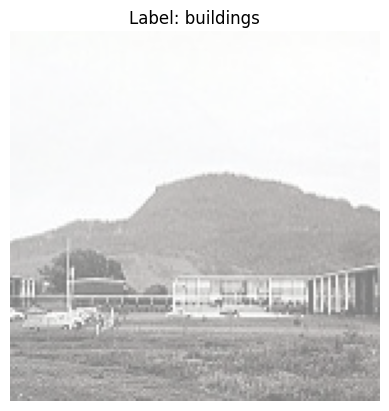

In [ ]:
print("Dataset type:", type(train_dataset))

first_image, first_label = train_dataset[0]

print(f"Shape of the first image: {first_image.shape}")

image_np = first_image.permute(1, 2, 0).numpy()
image_np = (image_np * 0.5) + 0.5

plt.imshow(image_np)
plt.title(f"Label: {train_dataset.classes[first_label]}")
plt.axis('off')
plt.show()

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [ ]:
class CustomSceneCNN(nn.Module):
    def __init__(self):
        super(CustomSceneCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = ResidualBlock(16, 16)
        self.layer2 = ResidualBlock(16, 32, stride=2)
        self.layer3 = ResidualBlock(32, 32)
        self.layer4 = ResidualBlock(32, 64, stride=2)
        self.layer5 = ResidualBlock(64, 64)
        self.layer6 = ResidualBlock(64, 128, stride=2)
        self.layer7 = ResidualBlock(128, 128)
        self.layer8 = ResidualBlock(128, 256, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 6)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # Forward pass through the new residual blocks
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
model = CustomSceneCNN().to(device)
print(model)

conv_layers = sum(1 for module in model.modules() if isinstance(module, nn.Conv2d))
print(f"Number of layers: {conv_layers}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CustomSceneCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

## CustomSceneCNN

The model used for image classification in this notebook is a Convolutional Neural Network (CNN), incorporating Residual Blocks to enhance performance and learning. The following is about the compoments of the model;

**1. Convolutional Layers:**

A basic convolutional layer. An Adaptive Average Pooling is also used to reduce the spatial dimensions of the feature maps.

**2. Residual Blocks:**

Residual blocks used skip connections, allowing information to flow directly from the input to the output of the block. This makes the performance of the model higher.

**3. Fully Connected Layers:**

This is the part of the classifier.

**4. Activation Functions and Regularization:**

- ReLU activation is used.
- Batch Normalization and Dropout is for Regularization to prevent overfitting.

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, target).item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total

    return test_loss, test_accuracy, all_preds, all_targets

In [ ]:
model_path = './intel_scene_cnn_model.pth'
history_path = './intel_scene_cnn_history.pth'

if os.path.exists(model_path):
    train_time_compute = 0
    print(f"Loading pre-trained model from {model_path}")
    model.load_state_dict(torch.load(model_path, weights_only=True))

    if os.path.exists(history_path):
        history = torch.load(history_path)
        train_losses = history['train_losses']
        train_accuracies = history['train_accuracies']
        test_losses = history['test_losses']
        test_accuracies = history['test_accuracies']
        print(f"Loaded training history for {len(train_losses)} epochs")
    else:
        print("No training history found. Evaluating current model performance...")
        test_loss, test_accuracy, _, _ = test(model, test_loader, criterion, device)
        print(f'Loaded Model Test Accuracy: {test_accuracy:.2f}%')
        train_losses = [0]
        test_losses = [test_loss]
        train_accuracies = [0]
        test_accuracies = [test_accuracy]
else:
    print("No previously trained model found. Training from scratch...")
    train_time_compute = 0
    start_time = time.time()
    max_epochs = 20
    patience = 3
    best_accuracy = 0
    no_improve_count = 0

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(max_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_accuracy, _, _ = test(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{max_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), model_path)
            print(f"Model improved, saved to {model_path}")
            no_improve_count = 0
        else:
            no_improve_count += 1
            print(f"No improvement for {no_improve_count} epochs")

        history = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies
        }
        torch.save(history, history_path)

        if no_improve_count >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training completed in {training_time:.2f} seconds')

    model.load_state_dict(torch.load(model_path, weights_only=True))
    print(f"Loaded best model with accuracy: {best_accuracy:.2f}%")
    print(f"Training history saved to {history_path}")


No previously trained model found. Training from scratch...
Epoch 1/20, Train Loss: 1.1384, Train Acc: 54.60%, Test Loss: 0.9039, Test Acc: 64.50%
Model improved, saved to ./intel_scene_cnn_model.pth
Epoch 2/20, Train Loss: 0.7509, Train Acc: 73.51%, Test Loss: 0.7082, Test Acc: 72.87%
Model improved, saved to ./intel_scene_cnn_model.pth
Epoch 3/20, Train Loss: 0.6363, Train Acc: 78.39%, Test Loss: 0.5370, Test Acc: 80.37%
Model improved, saved to ./intel_scene_cnn_model.pth
Epoch 4/20, Train Loss: 0.5685, Train Acc: 80.90%, Test Loss: 0.5912, Test Acc: 77.13%
No improvement for 1 epochs
Epoch 5/20, Train Loss: 0.5281, Train Acc: 82.59%, Test Loss: 0.5059, Test Acc: 82.17%
Model improved, saved to ./intel_scene_cnn_model.pth
Epoch 6/20, Train Loss: 0.4696, Train Acc: 84.46%, Test Loss: 0.4803, Test Acc: 83.33%
Model improved, saved to ./intel_scene_cnn_model.pth
Epoch 7/20, Train Loss: 0.4506, Train Acc: 85.03%, Test Loss: 0.4841, Test Acc: 83.00%
No improvement for 1 epochs
Epoch 8/20

Final Test Accuracy: 87.03%


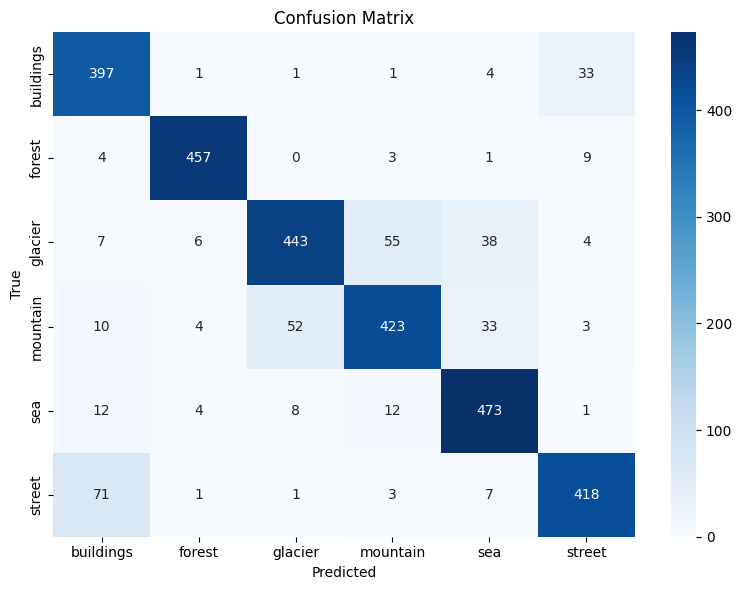

In [ ]:
if train_time_compute:
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training completed in {training_time:.2f} seconds')

_, final_accuracy, all_preds, all_targets = test(model, test_loader, criterion, device)
print(f'Final Test Accuracy: {final_accuracy:.2f}%')

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


The confusion matrix shows the performance of the trained CNN model on the Intel Image Classification dataset.  Each row represents the actual image class (buildings, forest, glacier, mountain, sea, street), and each column represents the predicted class.  The diagonal elements show the number of correctly classified images for each class.  Off-diagonal elements indicate misclassifications, with the value representing the number of images from a given true class that were incorrectly predicted as another class.

The model mostly classifies well among designated 6 classes, but some pairs such as (buildings, street), (glacier, mountain), and (glacier, sea) were quite misclassified. This is due to the dataset that an image have a similarity between them or contains both of them.